# SLIC Tutorial
- 本hands-onでは、教師なしセグメンテーション手法の1つであるSLICの実装を行う。
    - SLIC: Simple Linear Iterative Clustering
    
    
- SLICの3つのステップを順番に実装していく。
    - 課題1: セグメント初期化の実装
    - 課題2: 各ピクセルのセグメントへの割り当ての実装
    - 課題3: セグメント更新の実装

In [13]:
%matplotlib inline
import numpy as np
import skimage.data
from skimage.util import img_as_float, regular_grid
from skimage.color import rgb2lab
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

## 画像の読み込み
- skimage.dataから好きな画像を読み込もう。
- カラーで良い感じの画像リスト (推奨):
    - astronaut
    - chelsea (猫)
    - coffee
- モノクロで良い感じの画像リスト:
    - camera
    - coins

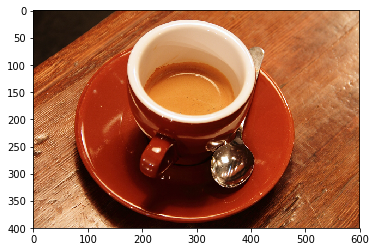

In [21]:
raw_img = skimage.data.coffee()
plt.imshow(raw_img)

- カラー画像の場合、RGB空間から[Lab空間](https://ja.wikipedia.org/wiki/Lab%E8%89%B2%E7%A9%BA%E9%96%93)に変換する
    - 色空間内での距離を人間の知覚と近くするため

In [22]:
image = img_as_float(raw_img)  # 0〜1のfloatに変換
if image.ndim == 2:  # モノクロ
    image = image[..., np.newaxis] - 0.5
else:  # カラー
    image = rgb2lab(raw_img)  # Lab空間に変換
    
print(image.shape)

(400, 600, 3)


## SLIC algorithm
- ほぼk-means。各ピクセルをセグメント (=k-meansで言うクラスタ) に割り振っていく。
- 距離の定義がポイント。座標距離と色距離の和。

### ハイパーパラメータ
- n_segments: セグメント数。k-meansで言うところのクラスタ数K。
- compactness: 座標距離と色距離のどちらを重視するかを決められる。compactnessが大きいほど座標距離を重視するため、各セグメントが正方形に近くなる。
- max_iter: 10でOK。

In [23]:
n_segments = 100
compactness = 10  # カラー画像->10, モノクロ画像->0.1くらいが良い
max_iter = 10

## 課題1: セグメントの初期化
- 各セグメントの中心座標と色の平均が入った配列segmentsを作成する。
- 要求仕様:
    - [[セグメント1のy座標, x座標, 色1, 色2, 色3],<br>[セグメント2のy座標, x座標, 色1, 色2, 色3],<br>...]<br>という形式の2次元配列にする。
    - x座標とy座標は下図のような等間隔の格子状に初期化する。
        - 間隔は、$step = \sqrt{\frac{height \, \times \, width}{n\_segments}}$
        - 最終的なセグメント数は上で指定したn_segmentsと同じにならないこともある。
    - 色は全て0で初期化する。
    - セグメントの順番は問わない。 
<div align="left">
<img src="figure/init.png", width=300, style="margin-left:0">
</div>

In [24]:
height, width = image.shape[:2]
step = int(np.sqrt(height * width * 1.0 / n_segments))

# WRITE ME!
coord_y = np.arange(step // 2, height, step)
coord_x = np.arange(step // 2, width, step)
n_segments = len(coord_y) * len(coord_x)  # 再計算

segments_coord = np.array(np.meshgrid(coord_y, coord_x)).reshape(2, n_segments).T  # shape=(n_segments, 2)
segments_color = np.zeros((n_segments, image.shape[2]))
segments = np.concatenate([segments_coord, segments_color], axis=1) 

### 確認

(96, 5)


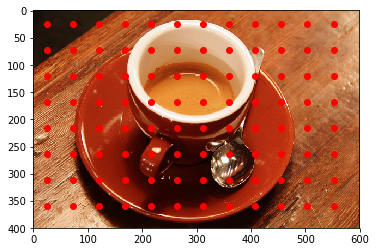

In [25]:
print(segments.shape)
plt.imshow(raw_img)
plt.plot(segments[:, 1], segments[:, 0], 'o', color='r')

## 課題2: 各ピクセルのセグメントへの割り当て / 課題3: セグメントの更新
- SLICのメインパートである2ステップを実装する。


- 課題2: 各ピクセルのセグメントへの割り当て
    - <u>**距離**</u>が最も近いセグメントに割り当てる。
$$
\begin{align}
d &= \sqrt{(d_{spatial} * compactness)^2 + d_{color}^2}, \\
{\rm where:} \\
d_{spatial} &= \frac{\sqrt{(x-x_c)^2 + (y-y_c)^2}}{step} \\
d_{color} &= \sqrt{(l-l_c)^2 + (a-a_c)^2 + (b-b_c)^2} \\
\end{align}
$$
    - 割り当て結果はnearest_segmentsに保存。
    - [実装済] 探索範囲は、各セグメントの中心の近傍のみ。
    - [実装済] 1点も更新されなかったらbreak。
    
    
- 課題3: セグメントの更新
    - 各segmentに割り当てられた全ての点の平均座標・色を計算し、segmentsに代入する。

In [26]:
nearest_segments = np.empty((height, width), dtype=np.intp)
n_segments = len(segments)  # 再定義

In [27]:
for i in tqdm(range(max_iter)):
    
    # 課題2: 各ピクセルをセグメントに割り当てる
    distance = np.ones((height, width)) * 1e08  # 距離格納用。めっちゃデカい初期値
    is_changed = False

    for k in range(n_segments):
        
        # セグメントの中心座標
        cy = segments[k, 0]
        cx = segments[k, 1]

        # 探索範囲はセグメント中心の近傍のみ
        y_min = int(max(cy - 2 * step, 0))
        y_max = int(min(cy + 2 * step + 1, height))
        x_min = int(max(cx - 2 * step, 0))
        x_max = int(min(cx + 2 * step + 1, width))

        # 距離を計算してセグメントに割り当てる
        for y in range(y_min, y_max):
            for x in range(x_min, x_max):
                dist_spatial = ((y - cy) ** 2 + (x - cx) ** 2) / step ** 2
                dist_color = np.sum((image[y, x] - segments[k, 2:]) ** 2)
                dist = dist_spatial * compactness ** 2 + dist_color
                
                if dist < distance[y, x]:
                    nearest_segments[y, x] = k
                    distance[y, x] = dist
                    is_changed = True

    # 1点も更新されなかったらbreak
    if not is_changed:
        break

    # 課題3: セグメントを更新する
    for k in range(n_segments):
        indices = np.where(nearest_segments == k)
        segments[k, 0] = np.mean(indices[0])
        segments[k, 1] = np.mean(indices[1])
        segments[k, 2:] = np.mean(image[indices], axis=0)

A Jupyter Widget

### 結果の表示

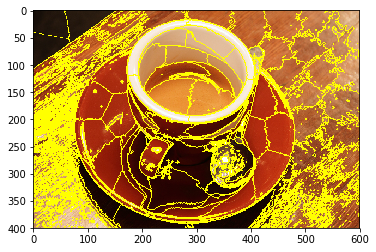

In [28]:
plt.imshow(mark_boundaries(raw_img, nearest_segments))

- 小さい不連続な領域を除去する処理を行うとさらに綺麗になる。
    - skiamgeの関数を拝借

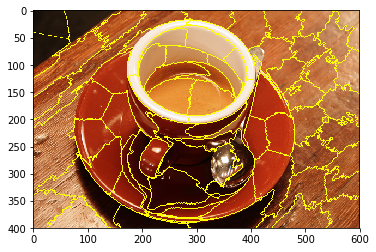

In [29]:
from skimage.segmentation._slic import _enforce_label_connectivity_cython

segment_size = height * width * 1.0 / n_segments
min_size = int(0.5 * segment_size)
max_size = int(3 * segment_size)

improved_nearest_segments = _enforce_label_connectivity_cython(nearest_segments[np.newaxis, ...],
                                                               n_segments,
                                                               min_size,
                                                               max_size)[0]

plt.imshow(mark_boundaries(raw_img, improved_nearest_segments))

### 参考資料
- skimageの実装: 
    - [skimage.segmentation.slic](https://github.com/scikit-image/scikit-image/blob/master/skimage/segmentation/slic_superpixels.py)
    - [_slic.pyx](https://github.com/scikit-image/scikit-image/blob/master/skimage/segmentation/_slic.pyx)
- 元論文: [SLIC Superpixels Compared to State-of-the-art Superpixel Methods](https://infoscience.epfl.ch/record/177415/files/Superpixel_PAMI2011-2.pdf)